# Quality Control of Whole Genome Sequencing

## Helper function

In [12]:
import os
import json
import pandas as pd
from pandas import json_normalize
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import seaborn as sns

# Ignore FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Suppress the UserWarning related to 'palette' and other warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Function to flatten the JSON and keep only leaf nodes
def flatten_json(json_obj, prefix=''):
    flat_data = {}
    for key, value in json_obj.items():
        # Check if value is a dictionary (i.e., nested) or if it's a leaf node
        if isinstance(value, dict):
            flat_data.update(flatten_json(value))  # Recursively flatten nested dictionaries
        else:
            flat_data[key] = value  # Leaf node, add to flat_data
    return flat_data

# Function to load the JSON in a DataFrame
def load_metrics(directory):
    
    # Initialize an empty list to store the parsed JSON data
    data_list = []
    
    # Iterate over all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith(".metrics.json"):  # Only process .json files
            filepath = os.path.join(directory, filename)
            # Open and load each JSON file
            with open(filepath, 'r') as f:
                data = json.load(f)
                # Flatten the JSON and keep only leaf nodes
                flat_data = flatten_json(data)
                # Append to the data list
                data_list.append(flat_data)
    
    # Create a DataFrame from the list of flat data
    df = pd.DataFrame(data_list)
    # Append sample info
    return append_info(df)

## Append sample info
def append_info(df):
    df_info = pd.read_csv('../n.100-1kg-sample-info-igsr.csv')
    df_merged = df.merge(df_info, left_on='id', right_on='Sample_name')
    return df_merged

# Function that plot the distribution of each metric in metrics.json file
def distribution(df, hue=None, palette='Set2'):
    # For each metric
    for col in df.columns[1:17]:
        # Create a scatter plot
        plt.figure(figsize=(10, 4))
        sns.scatterplot(data=df, x=df.index, y=col, hue=hue, palette=palette)
    
        # Calculate median and MAD
        median = df[col].median()
        # mad = np.mean(np.abs(dft[col] - median))
        
        # Add median and +/-3MAD lines
        plt.axhline(y=median, linestyle='--', color='red', label='Median')
        # plt.axhline(y=median + 3 * mad, linestyle='--', color='orange', label='+3xMAD')
        # plt.axhline(y=median - 3 * mad, linestyle='--', color='orange', label='-3xMAD')
        
        # Set plot title and labels
        plt.title(f"Scatter Plot for {col}")
        plt.xlabel("sample")
        plt.ylabel(col)
        plt.xticks([]) # Hide x-axis labels
        if col in formatter:
            plt.gca().yaxis.set_major_formatter(formatter[col])

        if col in ylims:
            plt.ylim(ylims[col][0], ylims[col][1])
    
        # Show legend
        plt.legend()
    
        # Show the plot
        plt.show()

In [13]:
# Specify metrics required EngFormatter
formatter = {
    'cross_contamination_rate': tkr.PercentFormatter(xmax=0.1),
    'yield_bp_q30': tkr.EngFormatter(),
    'count_deletions': tkr.EngFormatter(),
    'count_insertions': tkr.EngFormatter(),
    'count_snvs': tkr.EngFormatter(),
    
}
# Specify metrics ranges
ylims = {
    'cross_contamination_rate': [0, 0.1e-3]
}

## NPM-sample-QC v0.13.0

In [14]:
# Load metrics
dir = '../results-npm-sample-qc-v0.13.0'
df = load_metrics(dir)
df

,id,cross_contamination_rate,insert_size_std_deviation,mad_autosome_coverage,mean_autosome_coverage,mean_insert_size,pct_autosomes_15x,pct_reads_mapped,pct_reads_properly_paired,yield_bp_q30,...,ratio_transitions_transversions_snv,Sample_name,Sex,Biosample_ID,Population_code,Population_name,Superpopulation_code,Superpopulation_name,Population_elastic_ID,Data_collections
0,HG00100,6.159260e-10,99.4,4,29.94,430.1,95.90,99.78,98.2,102984371235,...,1.96,HG00100,female,SAME125154,GBR,British,EUR,European Ancestry,GBR,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
1,NA18530,3.422810e-08,101.5,5,32.22,444.7,96.04,99.71,97.8,110139268123,...,1.96,NA18530,male,SAME124484,CHB,Han Chinese,EAS,East Asian Ancestry,CHB,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
2,NA18525,4.081840e-08,100.3,5,31.40,444.1,95.93,99.73,98.0,107195224610,...,1.96,NA18525,female,SAME124672,CHB,Han Chinese,EAS,East Asian Ancestry,CHB,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
3,NA19025,1.955180e-09,100.9,5,32.26,436.9,95.98,99.79,98.1,111697530269,...,1.97,NA19025,male,SAME124852,LWK,Luhya,AFR,African Ancestry,LWK,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
4,NA19701,3.753950e-09,100.4,4,31.41,435.5,95.90,99.77,97.9,111450499179,...,1.97,NA19701,female,SAME124232,ASW,African Ancestry SW,AFR,African Ancestry,ASW,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,HG02601,3.510830e-06,100.4,4,29.54,441.5,95.80,99.75,98.0,106639572556,...,1.96,HG02601,female,SAME1840293,PJL,Punjabi,SAS,South Asian Ancestry,PJL,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
96,HG03718,6.584560e-04,93.6,4,28.83,415.0,95.72,99.69,97.6,98901640832,...,1.96,HG03718,male,SAME1839834,ITU,Telugu,SAS,South Asian Ancestry,ITU,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
97,HG01880,1.890120e-06,100.4,4,28.63,437.4,95.66,99.76,98.1,101207705433,...,1.97,HG01880,female,SAME1839109,ACB,African Caribbean,AFR,African Ancestry,ACB,"1000 Genomes on GRCh38,1000 Genomes 30x on GRC..."
98,NA19650,3.253230e-09,101.4,5,33.39,450.2,96.07,99.75,98.2,108960909689,...,1.96,NA19650,male,SAME124976,MXL,Mexican Ancestry,AMR,American Ancestry,MXL,"1000 Genomes 30x on GRCh38,Human Genome Struct..."


In [16]:
df['Superpopulation_code'].value_counts()

Superpopulation_code
AFR    28
EUR    20
SAS    20
EAS    18
AMR    14
Name: count, dtype: int64

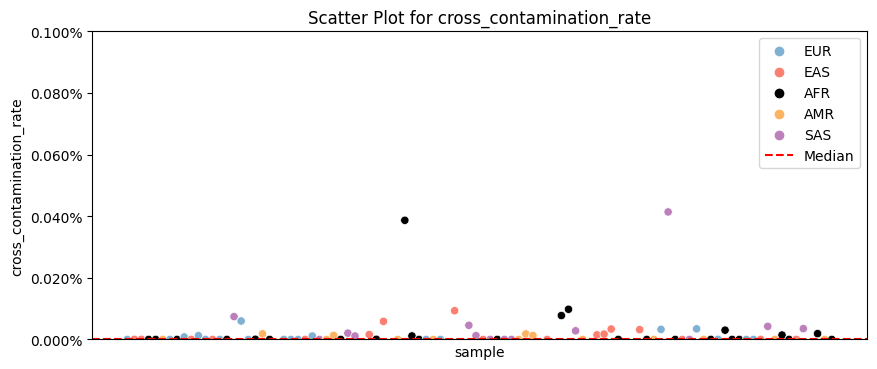

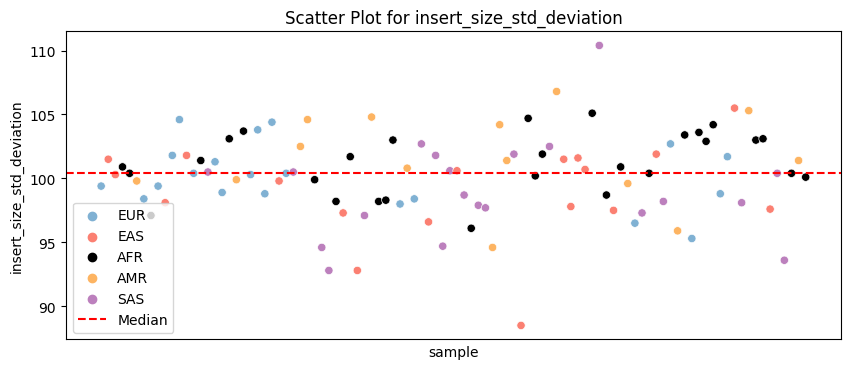

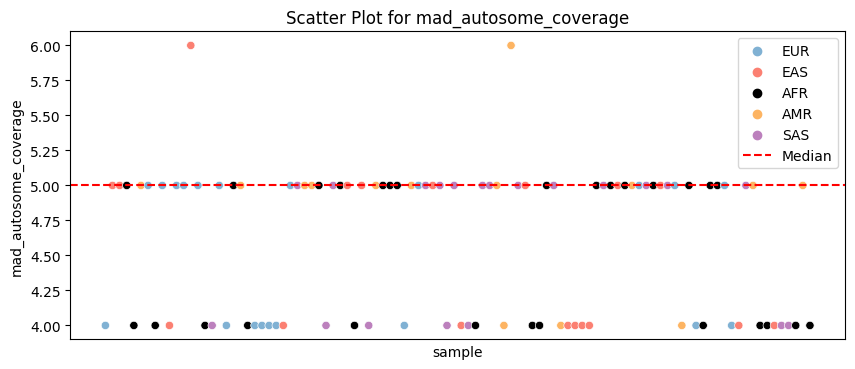

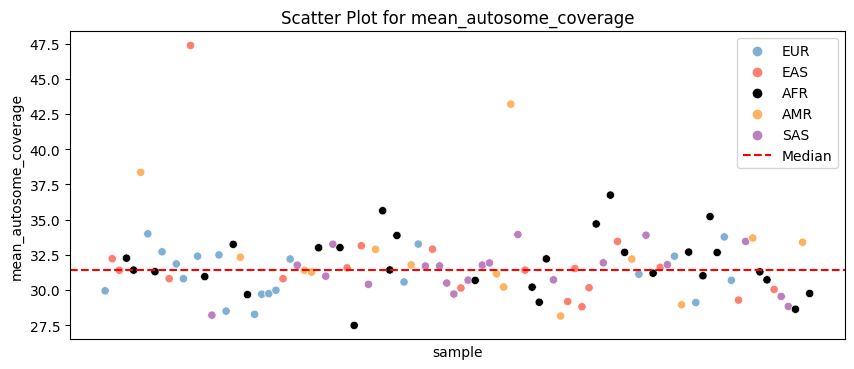

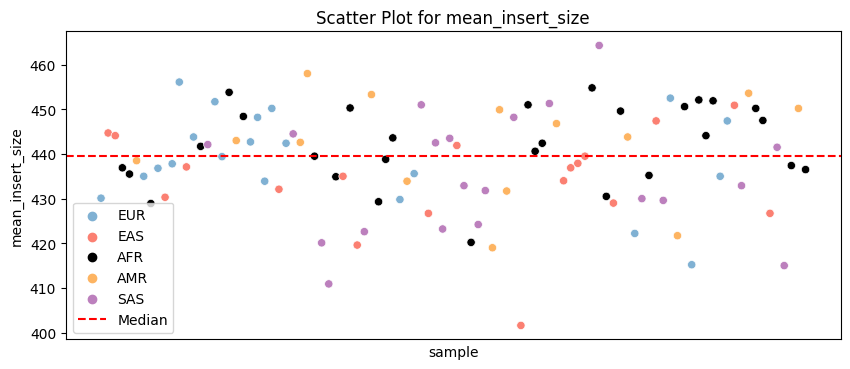

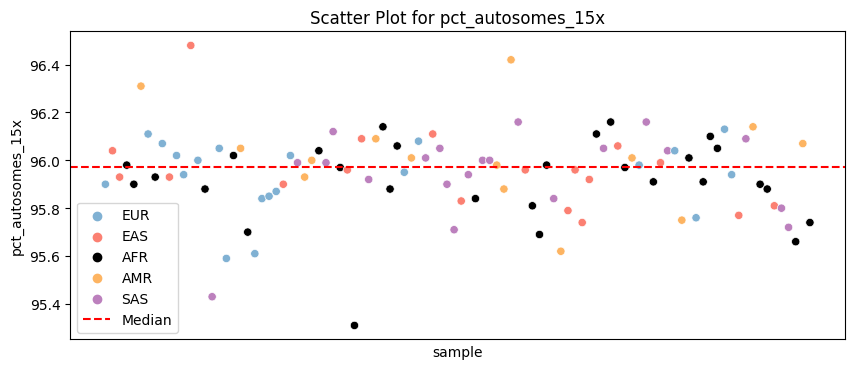

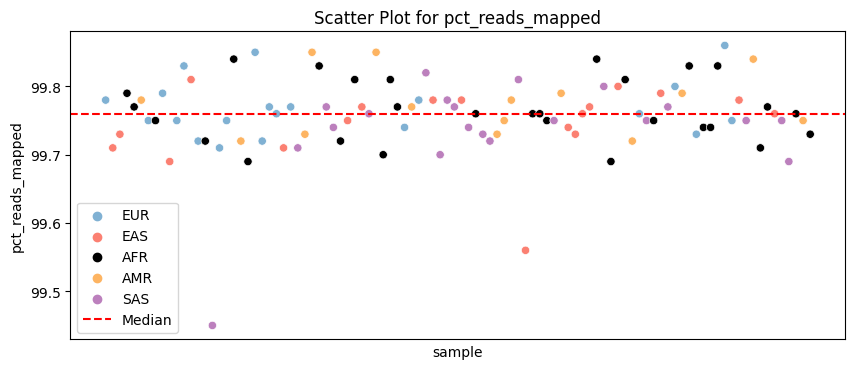

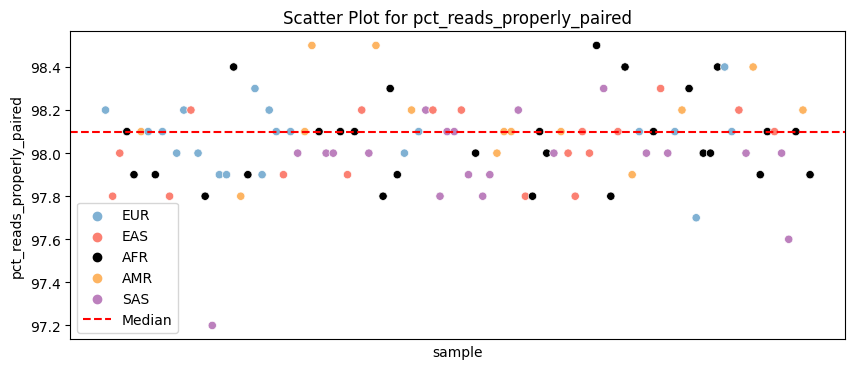

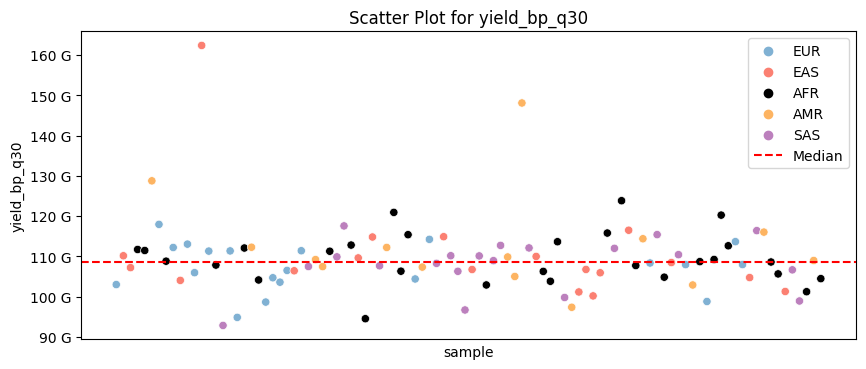

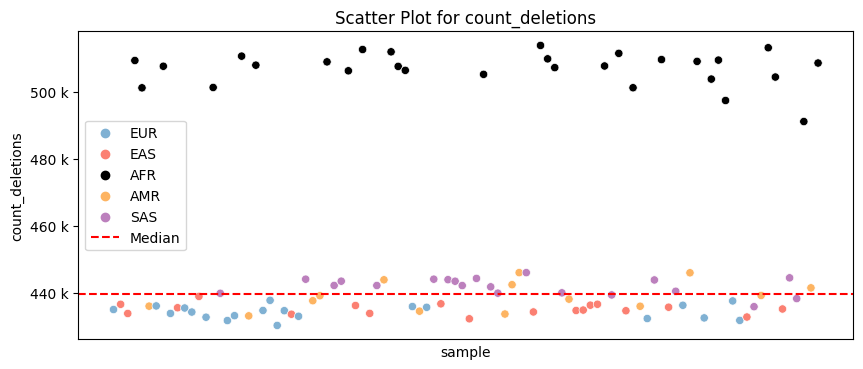

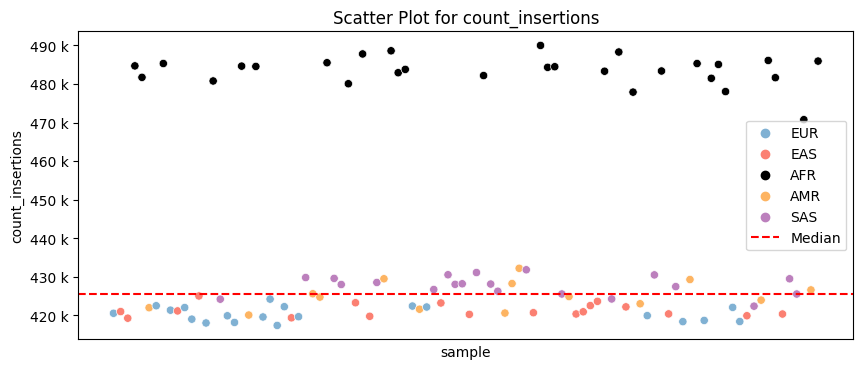

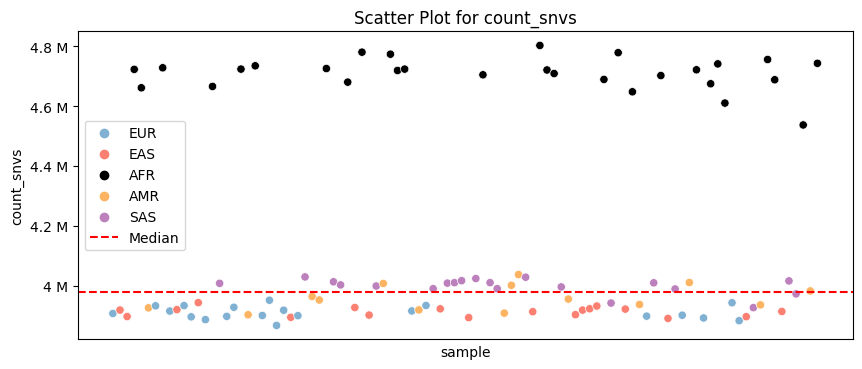

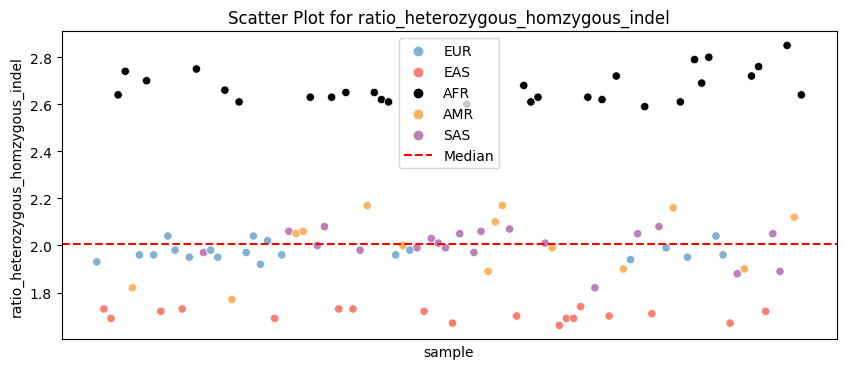

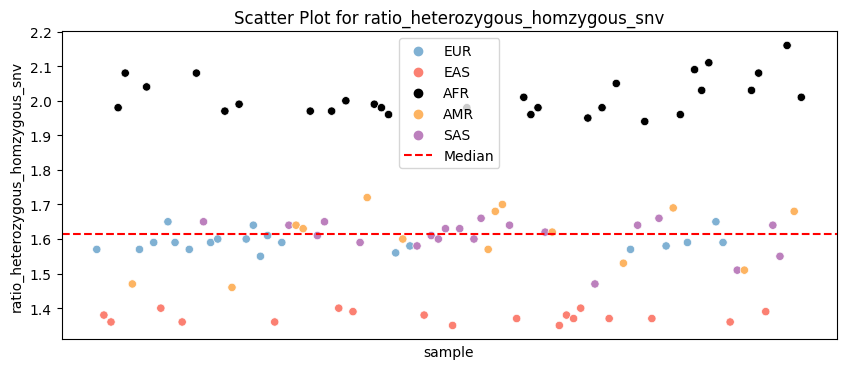

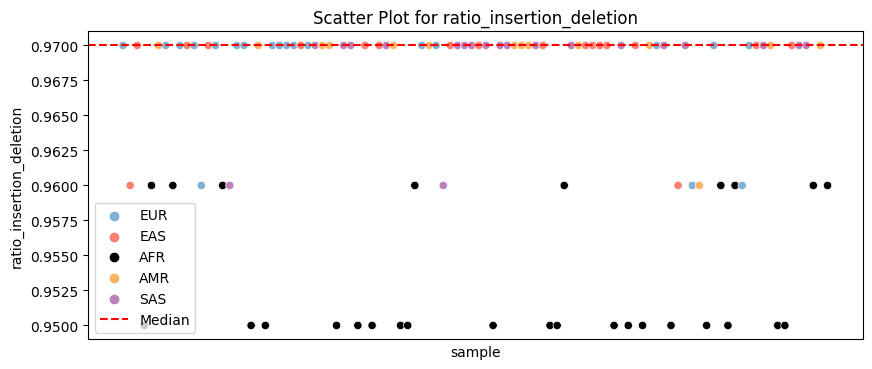

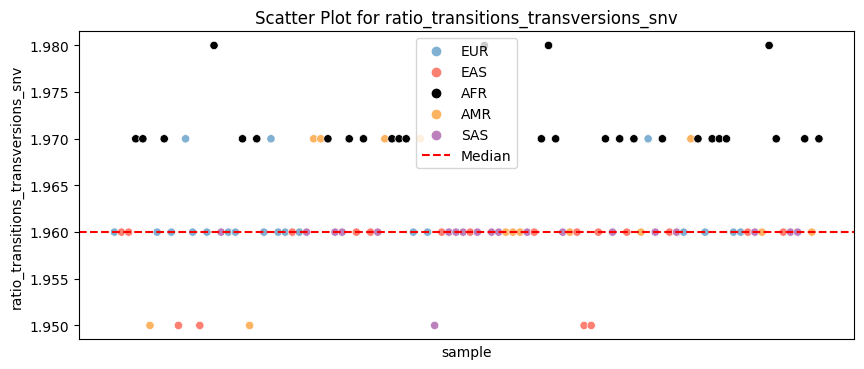

In [17]:
# Plot distribution for each metric
# Color sample by genetic ancestry
distribution(df, 'Superpopulation_code', {'AFR':'#000000', 'AMR': '#fdb462', 'EAS': '#fb8072', 'EUR': '#80b1d3', 'SAS': '#bc80bd'})


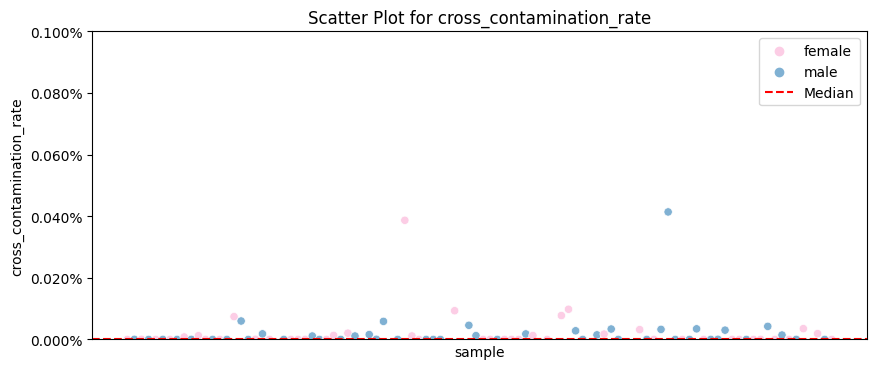

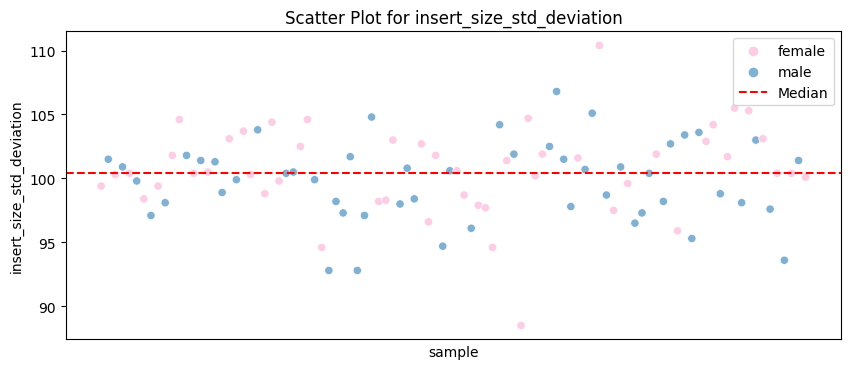

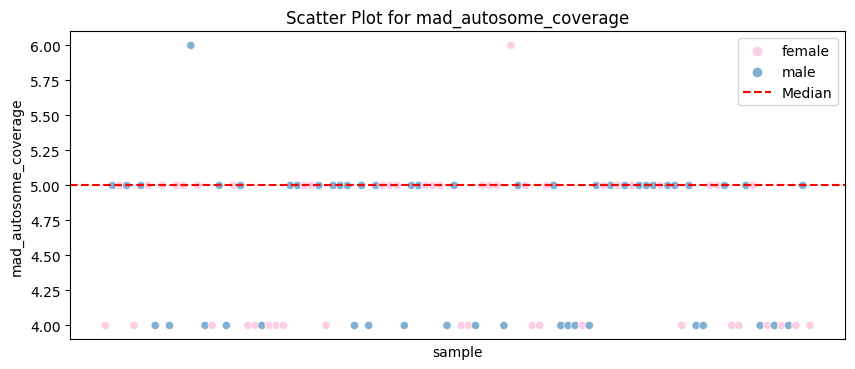

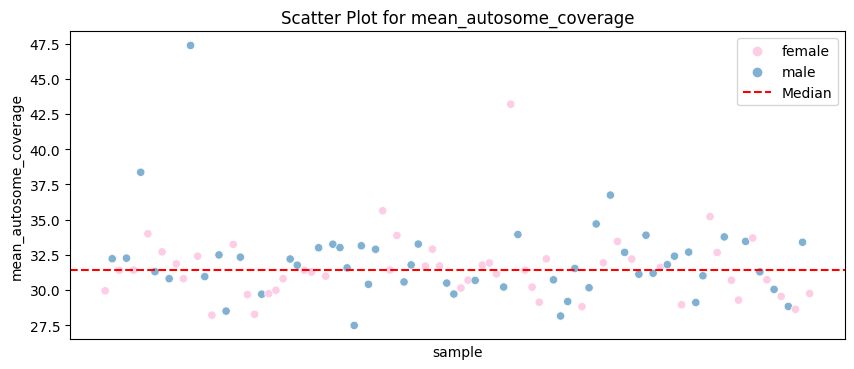

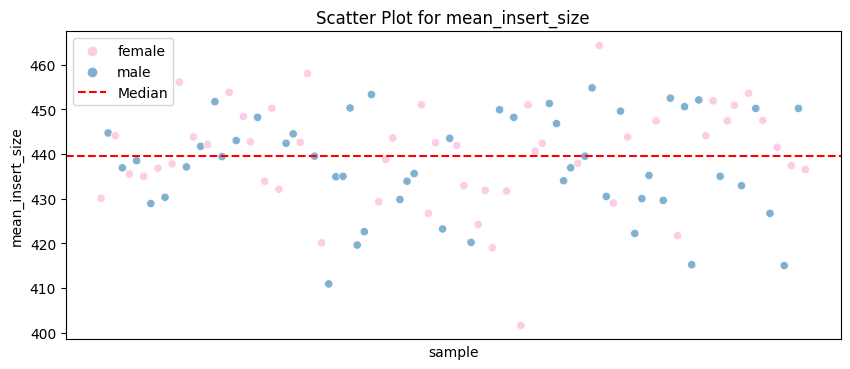

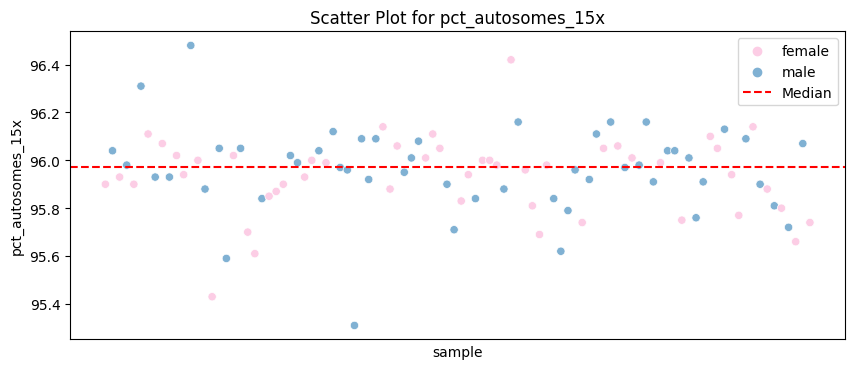

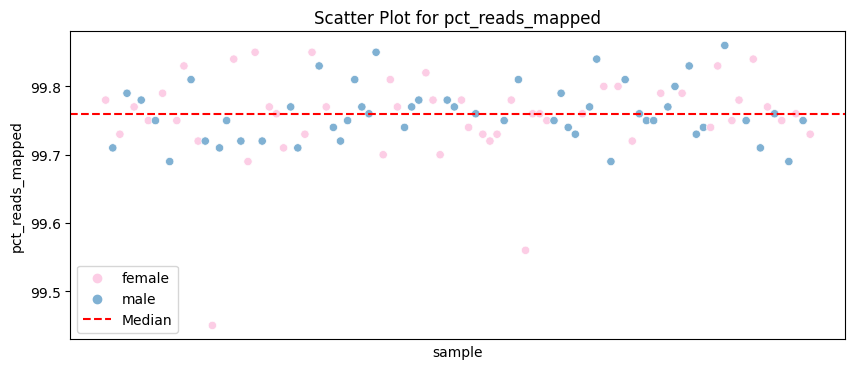

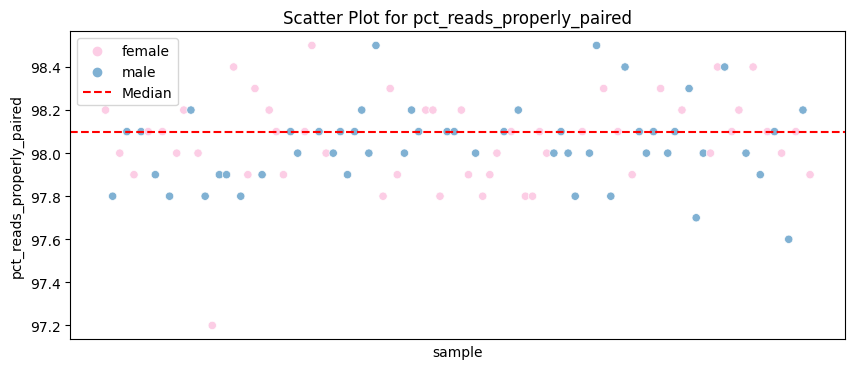

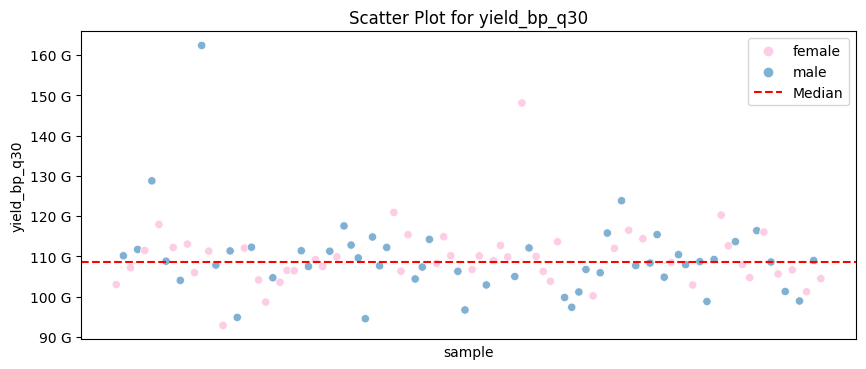

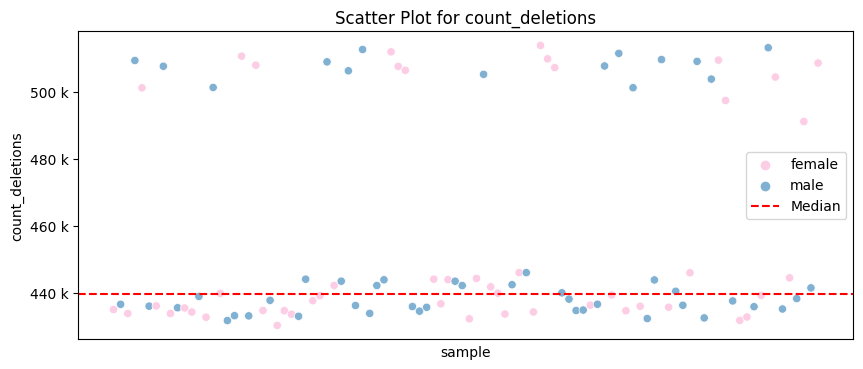

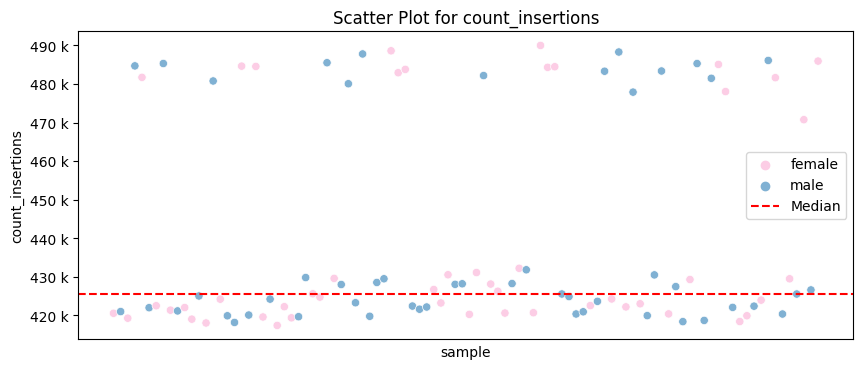

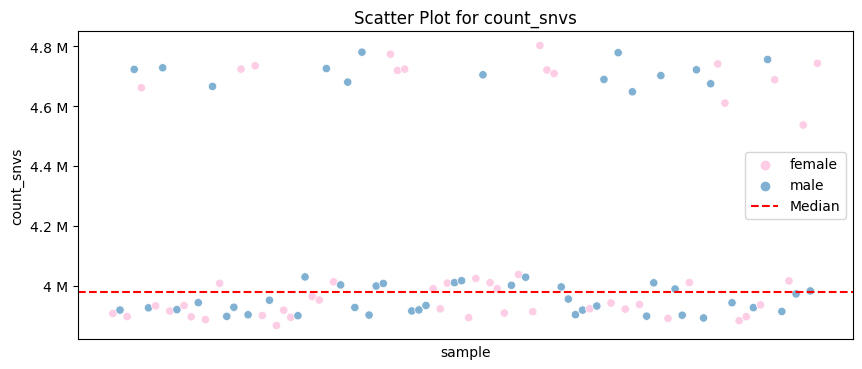

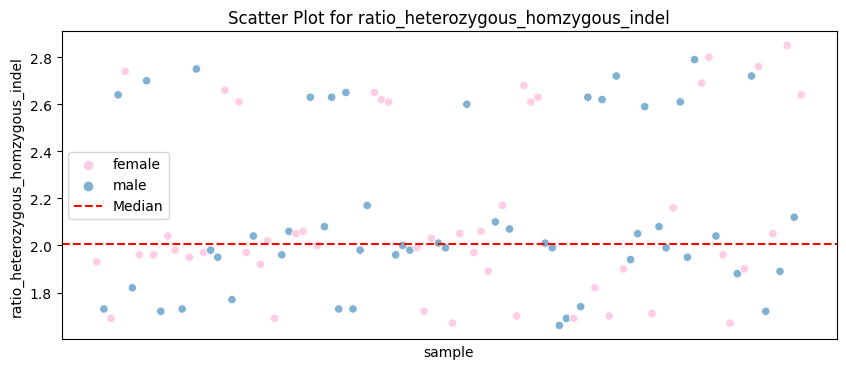

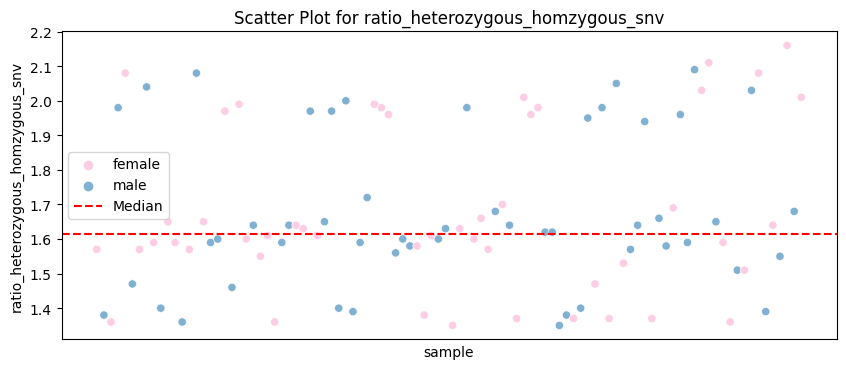

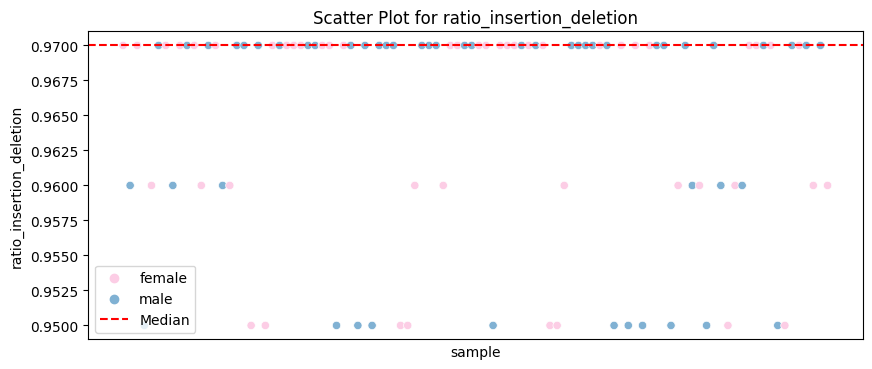

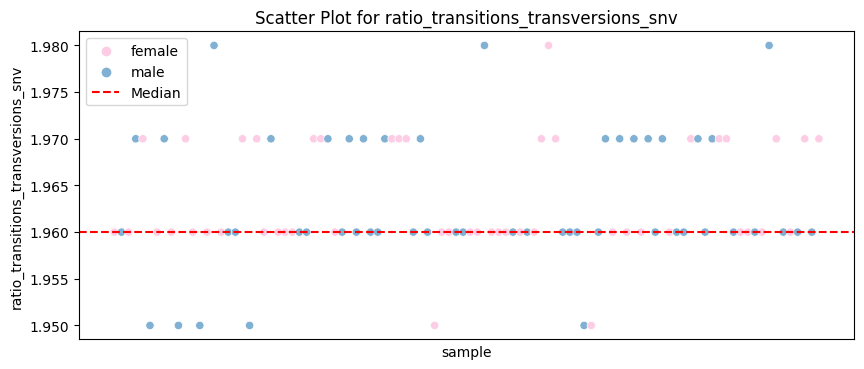

In [18]:
# Color sample by sex
distribution(df, 'Sex', {'male':'#80b1d3', 'female': '#fccde5'})